In [1]:
import numpy as np
import random
import os

import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D

def norm_x(x):
    for col in range(x.shape[1]):
        vals = x[:,col]
        vals = (vals-np.mean(vals))/np.std(vals)
        x[:,col] = vals
    return x

def sampleChania(Chania, n_points):
    np.random.seed(4)
    data = Chania[:,0:8]
    order = np.argsort(np.random.random(data.shape[0]))
    x = data[order][:n_points, 1:5]   
    trueusers = data[order][:n_points,0]
    n_clusters = 5
    x = norm_x(x)
    return tf.constant(x, dtype=tf.float32), tf.constant(trueusers, dtype=tf.float32)

Chania = np.genfromtxt('processedChania.csv', delimiter=',')

Chania = Chania[np.where(Chania[:,2]<99)]

In [64]:
NOISE = [50]
all_data = np.empty((10*len(NOISE),3))
average_data = np.empty((6,3))

for N in range(len(NOISE)):

    for i in range(10):

        strategy = "simple"

        sess = tf.Session()
        keras.backend.set_session(sess)

        x, trueusers = sampleChania(Chania, 100)

        if strategy == "simple":
            yarray = x.eval(session=sess) + np.random.normal(scale=NOISE[N], size=(100,4))
            y = tf.constant(yarray, tf.float32)

        i1 = keras.layers.Dense(4, activation=tf.nn.relu)
        i2 = keras.layers.Dense(4, activation=tf.nn.relu)
        i3 = keras.layers.Dense(4, activation=tf.nn.relu)
        i4 = keras.layers.Dense(1)

        m1 = i4(i3(i2(i1(x[:,2:]))))
        m1_target = tf.keras.backend.reshape(x[:,1], (100,1))
        m1_train = tf.train.GradientDescentOptimizer(0.2)
        m1_vars = [i1.variables, i2.variables, i3.variables, i4.variables]

        o1 = keras.layers.Dense(4, activation=tf.nn.relu)
        o2 = keras.layers.Dense(4, activation=tf.nn.relu)
        o3 = keras.layers.Dense(4, activation=tf.nn.relu)
        o4 = keras.layers.Dense(1)

        m2 = o4(o3(o2(o1(y[:,2:]))))
        m2_target = tf.keras.backend.reshape(y[:,1], (100,1))
        m2_train = tf.train.GradientDescentOptimizer(0.2)
        m2_vars = [o1.variables, o2.variables, o3.variables, o4.variables]

        a1 = keras.layers.Dense(7, activation=tf.nn.relu)
        a2 = keras.layers.Dense(5, activation=tf.nn.softmax)

        users = a2(a1(y))
        a_train = tf.train.GradientDescentOptimizer(0.08)
        a_vars = [a1.variables, a2.variables]

        m1_loss = tf.placeholder(tf.float32)
        m2_loss = tf.placeholder(tf.float32)
        map_error = tf.placeholder(tf.float32)
        adversary_loss = tf.placeholder(tf.float32)
        privatizer_loss = tf.placeholder(tf.float32)
        penalty = tf.placeholder(tf.float32)
        threshold = tf.placeholder(tf.float32)
        testpoints = tf.placeholder(tf.float32)
        grid = tf.placeholder(tf.float32)

        sess.run(tf.global_variables_initializer())

        m1_loss = tf.reduce_mean(tf.keras.losses.mean_squared_error(m1, m1_target))
        m1_train = m1_train.minimize(m1_loss, var_list = m1_vars)

        m2_loss = tf.reduce_mean(tf.keras.losses.mean_squared_error(m2, m2_target))
        m2_train = m2_train.minimize(m2_loss, var_list = m2_vars)

        adversary_loss = tf.reduce_mean(tf.keras.backend.sparse_categorical_crossentropy(trueusers, users))
        a_train = a_train.minimize(adversary_loss, var_list = a_vars)

        if strategy == "simple":
            combined = a2(a1(y))

        testpoints = np.mgrid[-1.5:0.75:15j, -1.5:0.75:15j].reshape(2,-1).T
        grid = tf.constant(testpoints, dtype=tf.float32)
        map_error = tf.reduce_mean(tf.squared_difference(
            i4(i3(i2(i1(grid)))),
            o4(o3(o2(o1(grid))))))

        def train(trainstep, trainloss, max_iter, session):
            plotlist = []
            delta1 = 100
            delta2 = 0
            count_iter = 0
            while abs(delta1 - delta2) >= 0.0001 and count_iter < max_iter:
                count_iter += 1
                delta1 = trainloss.eval(session=session)
                trainstep.run(session=session)
                delta2 = trainloss.eval(session=session)
                plotlist.append(trainloss.eval(session=session))
            return plotlist


        penalty = tf.constant(2.5, dtype=tf.float32)
        threshold = tf.constant(0, dtype=tf.float32)

        zero = tf.constant(0, dtype=tf.float32)
        privatizer_loss = tf.subtract(tf.multiply(penalty, tf.math.maximum(zero, tf.subtract(map_error, threshold))), 
                                      tf.reduce_mean(tf.keras.backend.sparse_categorical_crossentropy(trueusers, combined)))

        if strategy == "GAP":
            p_train = p_train.minimize(privatizer_loss, var_list = p_vars)

        if strategy == "simple":

            m2plot = train(m2_train, m2_loss, 1000, sess)    
            m1plot = train(m1_train, m1_loss, 1000, sess)
            aplot = train(a_train, adversary_loss, 1000, sess)    
            print(map_error.eval(session=sess), adversary_loss.eval(session=sess))

        index = int(10*N+i)
        all_data[index] = [NOISE[N], map_error.eval(session=sess), adversary_loss.eval(session=sess)]
        
        tf.keras.backend.clear_session()

    average_data[N] = [NOISE[N], np.mean(all_data[np.where(all_data[:,0]==NOISE[N])][:,1]), np.mean(all_data[np.where(all_data[:,0]==NOISE[N])][:,2])]


4.359895 1.1295406
6.1726255 1.1096244
4.0146303 1.0113467


KeyboardInterrupt: 

In [103]:
# all_data = all_data[np.where(np.isnan(all_data[:,1])==False)]

In [68]:
true_data = np.loadtxt("SimpleDataWorstAdversary")

In [109]:
# true_data = np.append(true_data, all_data, axis=0)

Text(0.5, 1.0, 'Privacy Utility Trade: Simple Privatizer, Worst Case Adversary')

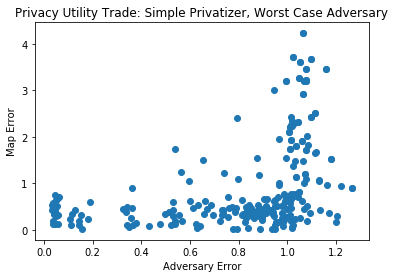

In [69]:
plt.scatter(true_data[:,2], true_data[:,1])
plt.xlabel("Adversary Error")
plt.ylabel("Map Error")
plt.title("Privacy Utility Trade: Simple Privatizer, Worst Case Adversary")

Text(0.5, 1.0, 'Privacy Utility Trade: Simple Privatizer, Worst Case Adversary')

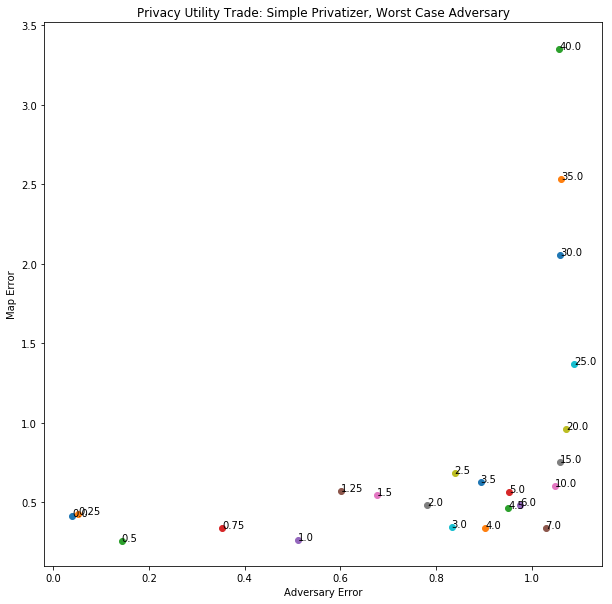

In [122]:
fig = plt.figure(figsize=(10,10))
for i in np.unique(true_data[:,0]):
    indices = np.where(true_data[:,0]==i)
    plt.scatter(np.mean(true_data[indices][:,2]), np.mean(true_data[indices][:,1]))
    plt.plot(np.mean(true_data[indices][:,2]), np.mean(true_data[indices][:,1]))
    plt.text(np.mean(true_data[indices][:,2]), np.mean(true_data[indices][:,1]), str(true_data[indices][0][0]))
plt.xlabel("Adversary Error")
plt.ylabel("Map Error")
plt.title("Privacy Utility Trade: Simple Privatizer, Worst Case Adversary")

In [3]:
def train(trainstep, trainloss, max_iter, session):
    plotlist = []
    delta1 = 100
    delta2 = 0
    count_iter = 0
    while abs(delta1 - delta2) >= 0.0001 and count_iter < max_iter:
        count_iter += 1
        delta1 = trainloss.eval(session=session)
        trainstep.run(session=session)
        delta2 = trainloss.eval(session=session)
        plotlist.append(trainloss.eval(session=session))
    return plotlist

In [57]:
def run_plot_automation():

    PENALTY = [0.25, 0.1, 0.2]
    I = 10
    all_data = np.empty((I*len(PENALTY),3))

    for P in range(len(PENALTY)):

        for i in range(I):

            strategy = "GAP"

            sess = tf.Session()
            keras.backend.set_session(sess)

            x, trueusers = sampleChania(Chania, 100)

            if strategy == "GAP":

                init = keras.initializers.Identity(gain=1.0)
                p1 = keras.layers.Dense(4, kernel_initializer=init, activation=tf.nn.relu)
                p2 = keras.layers.Dense(4, kernel_initializer=init, activation=tf.nn.relu)
                p3 = keras.layers.Dense(4, kernel_initializer=init, activation=tf.nn.relu)
                p4 = keras.layers.Dense(4, kernel_initializer=init, activation=tf.nn.relu)
                p5 = keras.layers.Dense(4, kernel_initializer=init)

                y = p5(p4(p3(p2(p1(x)))))
                p_vars = [p1.variables, p2.variables, p3.variables, p4.variables, p5.variables]

            i1 = keras.layers.Dense(4, activation=tf.nn.relu)
            i2 = keras.layers.Dense(4, activation=tf.nn.relu)
            i3 = keras.layers.Dense(4, activation=tf.nn.relu)
            i4 = keras.layers.Dense(1)

            m1 = i4(i3(i2(i1(x[:,2:]))))
            m1_target = tf.keras.backend.reshape(x[:,1], (100,1))
            m1_train = tf.train.GradientDescentOptimizer(0.2)
            m1_vars = [i1.variables, i2.variables, i3.variables, i4.variables]

            o1 = keras.layers.Dense(4, activation=tf.nn.relu)
            o2 = keras.layers.Dense(4, activation=tf.nn.relu)
            o3 = keras.layers.Dense(4, activation=tf.nn.relu)
            o4 = keras.layers.Dense(1)

            m2 = o4(o3(o2(o1(y[:,2:]))))
            m2_target = tf.keras.backend.reshape(y[:,1], (100,1))
            m2_train = tf.train.GradientDescentOptimizer(0.2)
            m2_vars = [o1.variables, o2.variables, o3.variables, o4.variables]

            a1 = keras.layers.Dense(7, activation=tf.nn.relu)
            a2 = keras.layers.Dense(5, activation=tf.nn.softmax)

            users = a2(a1(y))
            a_train = tf.train.GradientDescentOptimizer(0.08)
            a_vars = [a1.variables, a2.variables]

            m1_loss = tf.placeholder(tf.float32)
            m2_loss = tf.placeholder(tf.float32)
            adversary_loss = tf.placeholder(tf.float32)
            privatizer_loss = tf.placeholder(tf.float32)
            sanity_check = tf.placeholder(tf.float32)
            penalty = tf.placeholder(tf.float32)
            threshold = tf.placeholder(tf.float32)
            testpoints = tf.placeholder(tf.float32)
            grid = tf.placeholder(tf.float32)

            sess.run(tf.global_variables_initializer())

            m1_loss = tf.reduce_mean(tf.keras.losses.mean_squared_error(m1, m1_target))
            m1_train = m1_train.minimize(m1_loss, var_list = m1_vars)

            m2_loss = tf.reduce_mean(tf.keras.losses.mean_squared_error(m2, m2_target))
            m2_train = m2_train.minimize(m2_loss, var_list = m2_vars)

            adversary_loss = tf.reduce_mean(tf.keras.backend.sparse_categorical_crossentropy(trueusers, users))
            a_train = a_train.minimize(adversary_loss, var_list = a_vars)

            if strategy == "GAP":
                combined = a2(a1(p5(p4(p3(p2(p1(x)))))))
                p_train = tf.train.GradientDescentOptimizer(0.05)

                sanity_check_train = tf.train.GradientDescentOptimizer(0.1)

            testpoints = np.mgrid[-1.5:0.75:15j, -1.5:0.75:15j].reshape(2,-1).T
            grid = tf.constant(testpoints, dtype=tf.float32)

            penalty = tf.constant(PENALTY[P], dtype=tf.float32)
            threshold = tf.constant(0, dtype=tf.float32)

            zero = tf.constant(0, dtype=tf.float32)
#             tf.reduce_mean(tf.squared_difference(i4(i3(i2(i1(grid)))),o4(o3(o2(o1(grid))))))
            privatizer_loss = tf.subtract(tf.multiply(penalty, tf.math.maximum(zero, tf.subtract(tf.reduce_mean(tf.keras.losses.mean_squared_error(i4(i3(i2(i1(y[:,2:])))), 
                                                                                o4(o3(o2(o1(y[:,2:])))))), threshold))),
                                          tf.reduce_mean(tf.keras.backend.sparse_categorical_crossentropy(trueusers, combined)))
                        
        
#             privatizer_loss = tf.reduce_mean(tf.keras.losses.mean_squared_error(i4(i3(i2(i1(y[:,2:])))), 
#                                                                                 o4(o3(o2(o1(y[:,2:]))))))
        
            if strategy == "GAP":
                p_train = p_train.minimize(privatizer_loss, var_list = p_vars)

            sanity_check = tf.reduce_mean(tf.keras.losses.mean_squared_error(y, x))
            sanity_check_train = sanity_check_train.minimize(sanity_check, var_list = p_vars)

            delta1 = 1
            delta2 = 0
            count_iter = 0
            max_iter = 100

            while abs(delta1 - delta2) >= 0.0001 and count_iter < max_iter:

                delta1 = privatizer_loss.eval(session=sess)
                m2plot = train(m2_train, m2_loss, 1000, sess)
                m1plot = train(m1_train, m1_loss, 1000, sess)
                aplot = train(a_train, adversary_loss, 1000, sess)
                pplot = train(p_train, privatizer_loss, 1, sess)
                delta2 = privatizer_loss.eval(session=sess)

                count_iter += 1
                
            index = int(I*P+i)
            
            map_error = tf.reduce_mean(tf.keras.losses.mean_squared_error(i4(i3(i2(i1(y[:,2:])))), 
                                                                                o4(o3(o2(o1(y[:,2:]))))))
            print(map_error.eval(session=sess), adversary_loss.eval(session=sess))
            
            all_data[index] = [PENALTY[P], map_error.eval(session=sess), adversary_loss.eval(session=sess)]

            tf.keras.backend.clear_session()
            
    return all_data
            
all_data = run_plot_automation()

0.008872765 1.1934493
0.09035536 0.6367558
0.068948954 1.1041381
0.012124062 1.2414236
0.016248636 1.2563765
0.0023037652 1.316063
0.07676877 1.2144141
0.056539975 2.6346602
0.0015145591 1.21257
0.0007726442 1.2432678
0.064594254 1.2451842
0.04398344 1.2337906
0.061150774 0.65359765
0.0017471473 1.2518331
0.4854477 1.2396367
0.06800584 1.2710214
0.09793234 1.2445871
0.103415385 1.2464184
0.00027546546 1.2335694
0.12691112 0.16052994
0.030624416 1.2459464
0.17975488 0.1644385
0.1206864 1.2286566
0.039180234 1.2450546
0.03317536 1.2434125
0.062119875 0.165453
0.22663403 0.15813771
0.50317466 1.2537355
0.0057603125 0.42903343
0.3082352 0.6327216


In [58]:
all_data

array([[2.50000000e-01, 8.87276512e-03, 1.19344926e+00],
       [2.50000000e-01, 9.03553590e-02, 6.36755824e-01],
       [2.50000000e-01, 6.89489543e-02, 1.10413814e+00],
       [2.50000000e-01, 1.21240616e-02, 1.24142361e+00],
       [2.50000000e-01, 1.62486359e-02, 1.25637650e+00],
       [2.50000000e-01, 2.30376516e-03, 1.31606305e+00],
       [2.50000000e-01, 7.67687708e-02, 1.21441412e+00],
       [2.50000000e-01, 5.65399751e-02, 2.63466024e+00],
       [2.50000000e-01, 1.51455915e-03, 1.21256995e+00],
       [2.50000000e-01, 7.72644184e-04, 1.24326777e+00],
       [1.00000000e-01, 6.45942539e-02, 1.24518418e+00],
       [1.00000000e-01, 4.39834408e-02, 1.23379064e+00],
       [1.00000000e-01, 6.11507744e-02, 6.53597653e-01],
       [1.00000000e-01, 1.74714730e-03, 1.25183308e+00],
       [1.00000000e-01, 4.85447705e-01, 1.23963666e+00],
       [1.00000000e-01, 6.80058375e-02, 1.27102137e+00],
       [1.00000000e-01, 9.79323387e-02, 1.24458706e+00],
       [1.00000000e-01, 1.03415

In [61]:
GAP_data = np.append(GAP_data, all_data, axis=0)

In [54]:
GAP_data = GAP_data[np.where(GAP_data[:,2] < 2)]

In [59]:
lossprime_data = GAP_data

In [60]:
np.savetxt("lossprime_data.txt", lossprime_data)

In [50]:
GAP_data = np.loadtxt("lossprime_data.txt")

Text(0.5, 1.0, 'Privacy Utility Trade: Simple Privatizer, Worst Case Adversary')

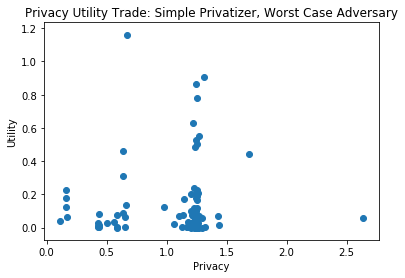

In [62]:
plt.scatter(GAP_data[:,2], GAP_data[:,1])
plt.xlabel("Privacy")
plt.ylabel("Utility")
plt.title("Privacy Utility Trade: GAP Privatizer, Worst Case Adversary")

Text(0.5, 1.0, 'Privacy Utility Trade: Simple Privatizer, Worst Case Adversary')

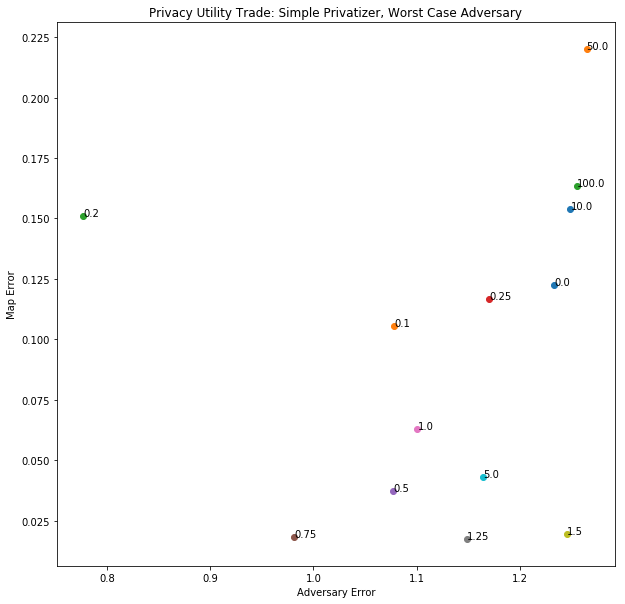

In [63]:
fig = plt.figure(figsize=(10,10))
for i in np.unique(GAP_data[:,0]):
    indices = np.where(GAP_data[:,0]==i)
    plt.scatter(np.mean(GAP_data[indices][:,2]), np.mean(GAP_data[indices][:,1]))
    plt.text(np.mean(GAP_data[indices][:,2]), np.mean(GAP_data[indices][:,1]), str(GAP_data[indices][0][0]))
plt.xlabel("Adversary Error")
plt.ylabel("Map Error")
plt.title("Privacy Utility Trade: GAP Privatizer, Worst Case Adversary")

In [73]:
NOISE = [0.25, 0.5, 0.75, 5]
all_data = np.empty((10*len(NOISE),3))
average_data = np.empty((6,3))

for N in range(len(NOISE)):

    for i in range(10):

        strategy = "simple"

        sess = tf.Session()
        keras.backend.set_session(sess)

        x, trueusers = sampleChania(Chania, 100)

        if strategy == "simple":
            yarray = x.eval(session=sess) + np.random.normal(scale=NOISE[N], size=(100,4))
            y = tf.constant(yarray, tf.float32)

        i1 = keras.layers.Dense(4, activation=tf.nn.relu)
        i2 = keras.layers.Dense(4, activation=tf.nn.relu)
        i3 = keras.layers.Dense(4, activation=tf.nn.relu)
        i4 = keras.layers.Dense(1)

        m1 = i4(i3(i2(i1(x[:,2:]))))
        m1_target = tf.keras.backend.reshape(x[:,1], (100,1))
        m1_train = tf.train.GradientDescentOptimizer(0.2)
        m1_vars = [i1.variables, i2.variables, i3.variables, i4.variables]

        o1 = keras.layers.Dense(4, activation=tf.nn.relu)
        o2 = keras.layers.Dense(4, activation=tf.nn.relu)
        o3 = keras.layers.Dense(4, activation=tf.nn.relu)
        o4 = keras.layers.Dense(1)

        m2 = o4(o3(o2(o1(y[:,2:]))))
        m2_target = tf.keras.backend.reshape(y[:,1], (100,1))
        m2_train = tf.train.GradientDescentOptimizer(0.2)
        m2_vars = [o1.variables, o2.variables, o3.variables, o4.variables]

        a1 = keras.layers.Dense(7, activation=tf.nn.relu)
        a2 = keras.layers.Dense(5, activation=tf.nn.softmax)

        users = a2(a1(y))
        a_train = tf.train.GradientDescentOptimizer(0.08)
        a_vars = [a1.variables, a2.variables]

        m1_loss = tf.placeholder(tf.float32)
        m2_loss = tf.placeholder(tf.float32)
        map_error = tf.placeholder(tf.float32)
        adversary_loss = tf.placeholder(tf.float32)
        privatizer_loss = tf.placeholder(tf.float32)
        penalty = tf.placeholder(tf.float32)
        threshold = tf.placeholder(tf.float32)
        testpoints = tf.placeholder(tf.float32)
        grid = tf.placeholder(tf.float32)

        sess.run(tf.global_variables_initializer())

        m1_loss = tf.reduce_mean(tf.keras.losses.mean_squared_error(m1, m1_target))
        m1_train = m1_train.minimize(m1_loss, var_list = m1_vars)

        m2_loss = tf.reduce_mean(tf.keras.losses.mean_squared_error(m2, m2_target))
        m2_train = m2_train.minimize(m2_loss, var_list = m2_vars)

        adversary_loss = tf.reduce_mean(tf.keras.backend.sparse_categorical_crossentropy(trueusers, users))
        a_train = a_train.minimize(adversary_loss, var_list = a_vars)

        if strategy == "simple":
            combined = a2(a1(y))

        testpoints = np.mgrid[-1.5:0.75:15j, -1.5:0.75:15j].reshape(2,-1).T
        grid = tf.constant(testpoints, dtype=tf.float32)
        map_error = tf.reduce_mean(tf.keras.losses.mean_squared_error(i4(i3(i2(i1(y[:,2:])))), 
                                                                                o4(o3(o2(o1(y[:,2:]))))))
        def train(trainstep, trainloss, max_iter, session):
            plotlist = []
            delta1 = 100
            delta2 = 0
            count_iter = 0
            while abs(delta1 - delta2) >= 0.0001 and count_iter < max_iter:
                count_iter += 1
                delta1 = trainloss.eval(session=session)
                trainstep.run(session=session)
                delta2 = trainloss.eval(session=session)
                plotlist.append(trainloss.eval(session=session))
            return plotlist

        if strategy == "simple":

            m2plot = train(m2_train, m2_loss, 1000, sess)    
            m1plot = train(m1_train, m1_loss, 1000, sess)
            aplot = train(a_train, adversary_loss, 1000, sess)    
            print(map_error.eval(session=sess), adversary_loss.eval(session=sess))

        index = int(10*N+i)
        all_data[index] = [NOISE[N], map_error.eval(session=sess), adversary_loss.eval(session=sess)]
        
        tf.keras.backend.clear_session()

    average_data[N] = [NOISE[N], np.mean(all_data[np.where(all_data[:,0]==NOISE[N])][:,1]), np.mean(all_data[np.where(all_data[:,0]==NOISE[N])][:,2])]


0.06813439 0.048997484
0.07289104 0.046035867
0.14664736 0.053235434
0.07063643 0.052061178
0.2317269 0.052218568
0.11332562 0.04463833
0.039666437 0.050692353
0.3859174 0.048148528
0.20480968 0.0790122
0.044404265 0.04774627
0.32893056 0.18171254
0.19681808 0.17256886
0.30462703 0.16517156
0.1509953 0.17415406
0.4414911 0.1586371
0.47086182 0.11137522
0.5566961 0.12730457
0.27682504 0.1303657
0.17294654 0.1352944
0.25421622 0.1319048
0.37194398 0.33549163
0.31152987 0.33782274
0.31543642 0.37322858
0.33612683 0.31815633
0.1676735 0.33648768
0.37776023 0.3065117
0.29293123 0.32859516
0.12344091 0.34667858
1.0611485 0.34688076
0.19143444 0.34286758
15.704747 0.8956775
8.463596 0.83057576
7.0320067 0.95092696
31.702314 0.9720219
7.166139 1.0731243
3.2833862 0.8644207
12.649467 0.98550445
24.268372 0.95903206
21.04526 1.0356392
7.6241975 1.060118


In [66]:
all_data = all_data[np.where(np.isnan(all_data[:,1])==False)]

In [108]:
# true_data = np.loadtxt("SimpleDataWorstAdversary")

In [74]:
true_data = np.append(true_data, all_data, axis=0)
# true_data = all_data

Text(0.5, 1.0, 'Privacy Utility Trade: Simple Privatizer, Worst Case Adversary')

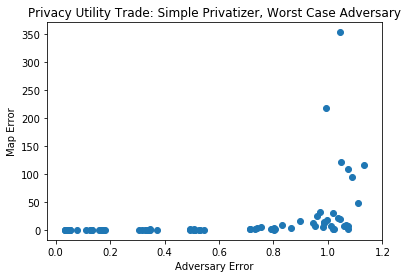

In [75]:
plt.scatter(true_data[:,2], true_data[:,1])
plt.xlabel("Adversary Error")
plt.ylabel("Map Error")
plt.title("Privacy Utility Trade: Simple Privatizer, Worst Case Adversary")

Text(0.5, 1.0, 'Privacy Utility Trade: Simple Privatizer, Worst Case Adversary')

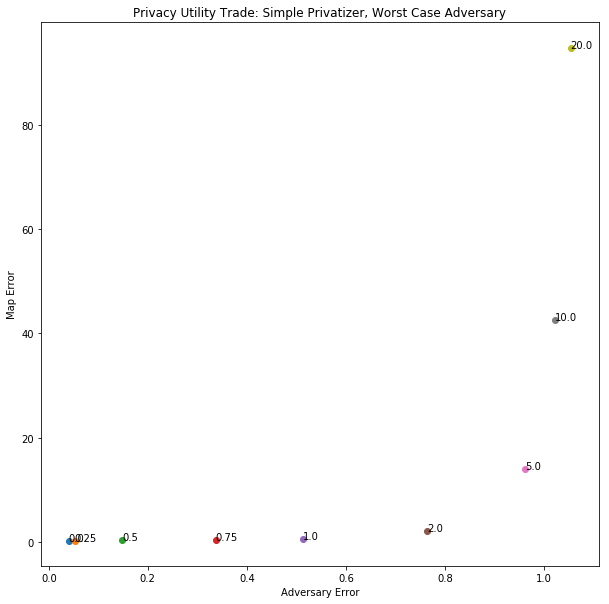

In [76]:
fig = plt.figure(figsize=(10,10))
for i in np.unique(true_data[:,0]):
    indices = np.where(true_data[:,0]==i)
    plt.scatter(np.mean(true_data[indices][:,2]), np.mean(true_data[indices][:,1]))
    plt.plot(np.mean(true_data[indices][:,2]), np.mean(true_data[indices][:,1]))
    plt.text(np.mean(true_data[indices][:,2]), np.mean(true_data[indices][:,1]), str(true_data[indices][0][0]))
plt.xlabel("Adversary Error")
plt.ylabel("Map Error")
plt.title("Privacy Utility Trade: Simple Privatizer, Worst Case Adversary")